### This notebook is a clone of the "Predict who will move to a new job - Siti Khotijah" for my practice purposes(Code Analysis about Best Practice).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
ls

Clone__Predict_who_will_move_to_a_new_job.ipynb
HR_Analytics.ipynb
data/


### Training Data

In [5]:
train = pd.read_csv('./data/aug_train.csv')

In [6]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Features
* enrollee_id : Unique ID for enrollee
* city: City code
* citydevelopmentindex: Developement index of the city (scaled)
* gender: Gender of enrolee
* relevent_experience: Relevent experience of enrolee
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of enrolee
* major_discipline :Education major discipline of enrolee
* experience: Enrolee total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

### Visualization
Here I did compare the features that might influence the move to a new job and get the max, min and mean of the features

In [7]:
train.columns = train.columns.str.strip()

In [8]:
train['gender'].unique()

array(['Male', nan, 'Female', 'Other'], dtype=object)

In [9]:
train['education_level'].unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

In [10]:
len(train.columns)

14

In [11]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

실수) Groupby()에 포함되는 컬럼은 반드시 참조하는 선행 컬럼(Df)에 포함되어야 함.

In [12]:
display(train[['city','city_development_index','relevent_experience','gender','education_level','major_discipline','experience','company_size','company_type','target']].\
        groupby(['gender','education_level','experience','company_size'])\
        .agg(['max','mean','min'])\
        .style.background_gradient(cmap='Oranges'))

### Bar plots
showing the frequency of each category seperated by label

In [34]:
plt.style.use('dark_background')

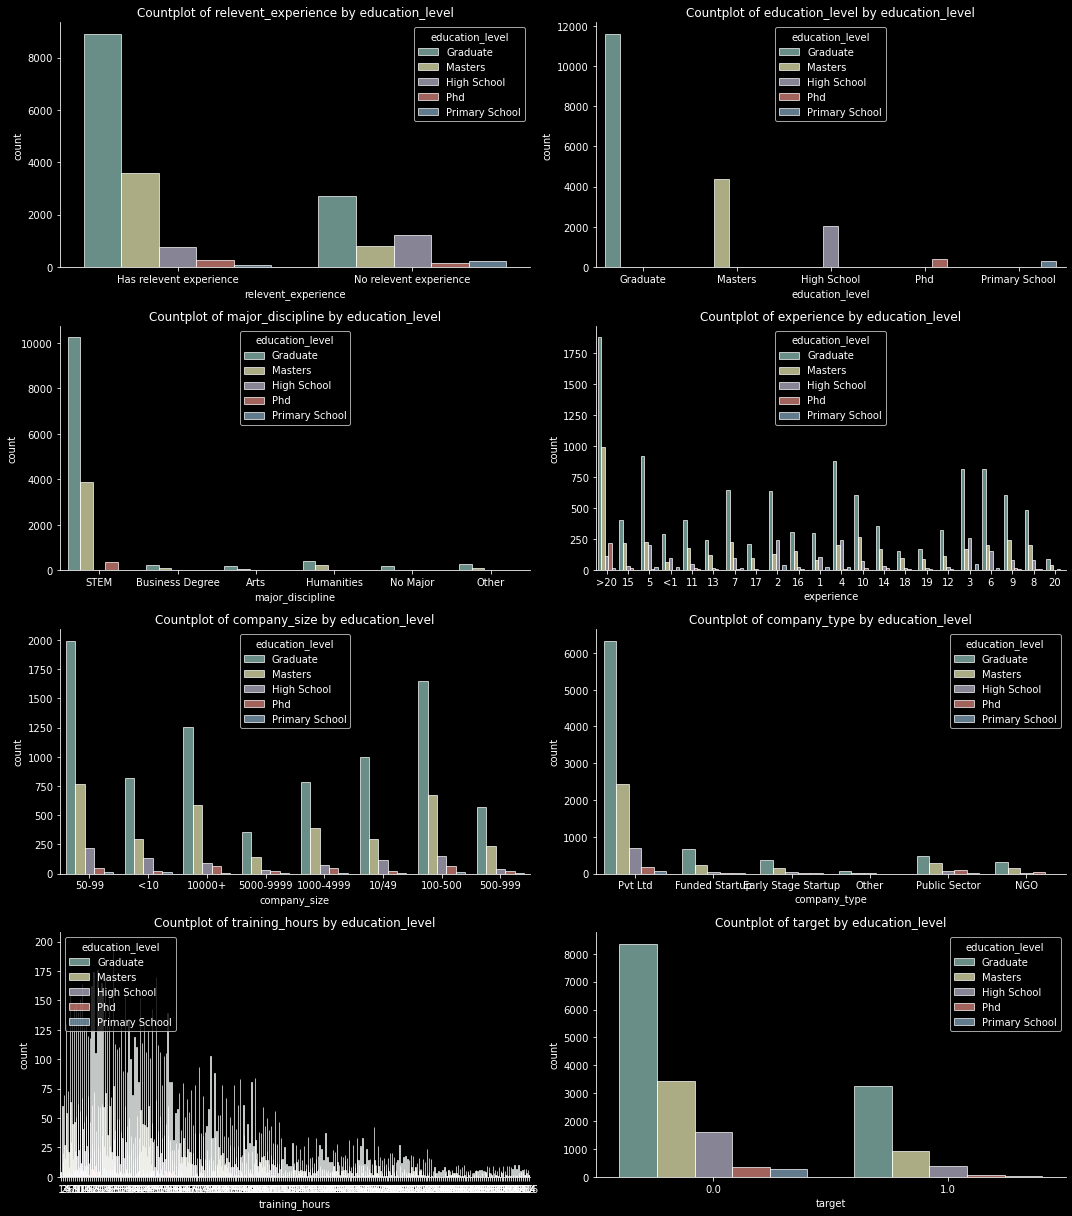

In [35]:
#barplots showing the frequency of each category separated by label
plt.figure(figsize=[15,17])
fft=['relevent_experience','education_level','major_discipline','experience','company_size','company_type','training_hours','target']
n=1
for f in fft:
    plt.subplot(4,2,n)
    sns.countplot(x=f, hue='education_level',edgecolor='white',alpha=0.7,data=train)
    sns.despine()
    plt.title('Countplot of {} by education_level'.format(f))
    n=n+1
plt.tight_layout()
plt.show()

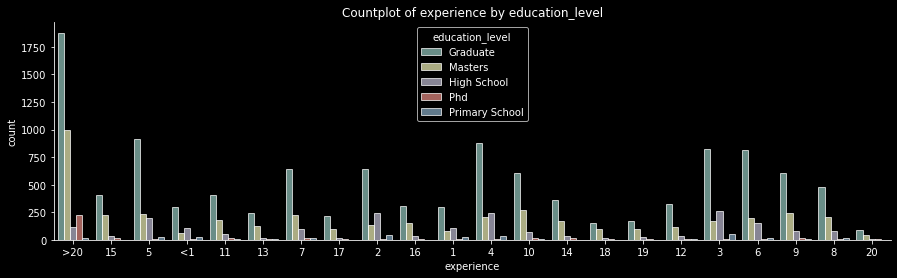

In [36]:
plt.figure(figsize=[15,4])
sns.countplot(x='experience', hue='education_level',edgecolor='white',alpha=0.7, data=train)
sns.despine()
plt.title('Countplot of experience by education_level')
plt.show()

sns.despine()은 테두리를 제거하는 메소드

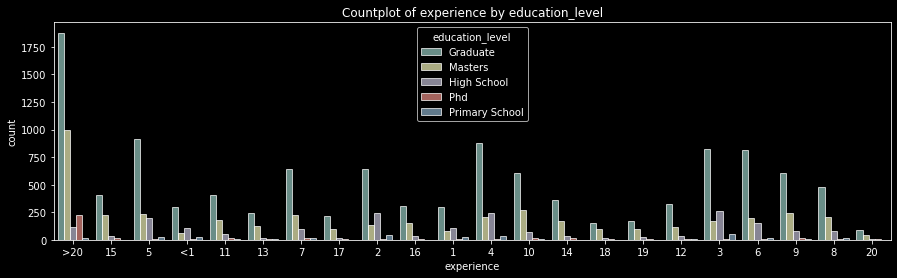

In [37]:
plt.figure(figsize=[15,4])
sns.countplot(x='experience', hue='education_level',edgecolor='white',alpha=0.7, data=train)
#sns.despine()
plt.title('Countplot of experience by education_level')
plt.show()

### Target
* 0 - Not Looking for a job change
* 1 - Looking for a job change

As you can see, here we have imbalanced data, the number of 1 (Looking for a job change) < 0 (Not Looking for a job change)

In [38]:
mnj = train['target'].value_counts()

In [39]:
mnj

0.0    14381
1.0     4777
Name: target, dtype: int64

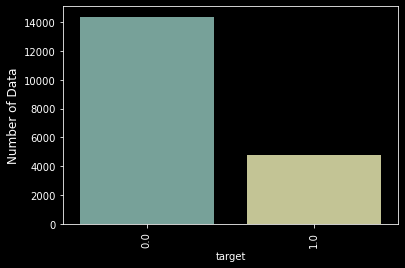

In [40]:
plt.figure(figsize=(6,4))
sns.barplot(mnj.index, mnj.values, alpha=0.8)
plt.ylabel('Number of Data', fontsize=12)
plt.xlabel('target',fontsize=10)
plt.xticks(rotation=90)
plt.show()

### Education Level
This dataset contains 5 education level:
* Graduate
* Masters
* High School
* PhD
* Primary School

In [41]:
EL = train['education_level'].value_counts()

In [42]:
EL

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

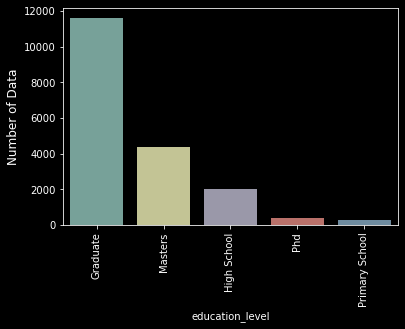

In [43]:
plt.figure(figsize=(6,4))
sns.barplot(EL.index, EL.values, alpha=0.8)
plt.ylabel('Number of Data', fontsize=12)
plt.xlabel('education_level',fontsize=10)
plt.xticks(rotation=90)
plt.show();

### Pie plot

In [44]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [45]:
train['education_level'].value_counts()

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [46]:
train['education_level'].value_counts().index

Index(['Graduate', 'Masters', 'High School', 'Phd', 'Primary School'], dtype='object')

In [47]:
train['education_level'].value_counts().reset_index()

,index,education_level
0,Graduate,11598
1,Masters,4361
2,High School,2017
3,Phd,414
4,Primary School,308


In [48]:
train['education_level'].value_counts().reset_index().index

RangeIndex(start=0, stop=5, step=1)

In [49]:
el = train['education_level'].value_counts().reset_index()

In [50]:
el.columns

Index(['index', 'education_level'], dtype='object')

In [51]:
el.columns = ['education_level','percent']

In [52]:
el['percent'] /= len(train)

In [53]:
el

,education_level,percent
0,Graduate,0.605387
1,Masters,0.227633
2,High School,0.105282
3,Phd,0.021610
4,Primary School,0.016077


In [54]:
el

,education_level,percent
0,Graduate,0.605387
1,Masters,0.227633
2,High School,0.105282
3,Phd,0.021610
4,Primary School,0.016077


**jupyter labextension install jupyterlab-plotly**

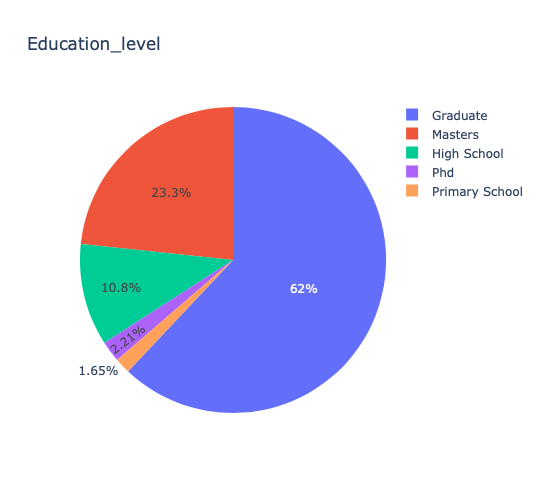

In [65]:
fig = px.pie(
    el, 
    names='education_level', 
    values='percent', 
    title='Education_level', 
    width=800,
    height=500
)
#color - dark_mode
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### Education_level : training_hours

In [66]:
train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [69]:
train.sort_values(by='training_hours',ascending=True)[:7000].tail()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1867,14572,city_21,0.624,Male,Has relevent experience,no_enrollment,Masters,STEM,8,50-99,Public Sector,4,33,1.0
2144,10937,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,1000-4999,Public Sector,>4,33,0.0
17405,29082,city_114,0.926,Male,No relevent experience,Full time course,High School,NaN,7,500-999,Pvt Ltd,1,33,0.0
9132,53,city_16,0.910,NaN,No relevent experience,Full time course,High School,NaN,7,NaN,Pvt Ltd,never,33,0.0
6882,9783,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,1000-4999,Pvt Ltd,>4,33,0.0


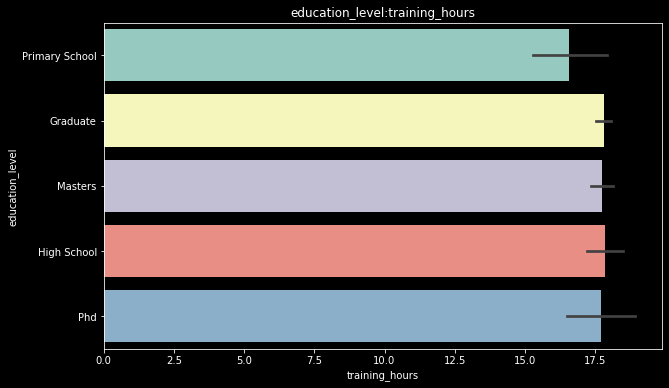

In [71]:
#training_hours 1~33시간까지만 추출
et = train.sort_values(by='training_hours',ascending=True)[:7000]
figure = plt.figure(figsize=(10,6))
sns.barplot(y=et.education_level, x=et.training_hours)
plt.xticks()
plt.xlabel('training_hours')
plt.ylabel('education_level')
plt.title('education_level:training_hours')
plt.show()

### City development index
The City Development Index was developed for the Second United Nations Conference on Human Settlements (Habitat II) in 1996 and measures the level of development in cities. The Urban Indicators Programme of the United Nations Human Settlements Programme (UN-Habitat) developed the indicator so that they could rank cities of the world according to their level of development and as a display of indicators depicting development. The CDI cuts across the different clusters identified in the Urban Indicator Framework as it is based on five sub indices namely, infrastructure, waste, health, education and city product. It is useful as it provides a snap-shot view of how cities are doing with respect to the different indices. It was invented by Dr Joe Flood, first Coordinator of the Urban Indicators Program, following a statistical analysis of city indicators data. Reference :https://en.wikipedia.org/wiki/City_development_index

In [72]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [74]:
train['city_development_index']

0        0.920
1        0.776
2        0.624
3        0.789
4        0.767
         ...  
19153    0.878
19154    0.920
19155    0.920
19156    0.802
19157    0.855
Name: city_development_index, Length: 19158, dtype: float64

In [75]:
train['city_development_index'].value_counts()

0.920    5200
0.624    2702
0.910    1533
0.926    1336
0.698     683
         ... 
0.649       4
0.807       4
0.781       3
0.625       3
0.664       1
Name: city_development_index, Length: 93, dtype: int64

In [76]:
train['city_development_index'].value_counts().reset_index()

,index,city_development_index
0,0.920,5200
1,0.624,2702
2,0.910,1533
3,0.926,1336
4,0.698,683
...,...,...
88,0.649,4
89,0.807,4
90,0.781,3
91,0.625,3


In [77]:
cdi = train['city_development_index'].value_counts().reset_index()
cdi.columns = [
    'city_development_index',
    'count'
]

In [79]:
cdi['city_development_index'] = cdi['city_development_index'].\
    astype(str) + '-'
cdi = cdi.sort_values(['count']).tail(50)

In [80]:
cdi

,city_development_index,count
49,0.691-,45
48,0.848-,47
47,0.7659999999999999-,49
46,0.727-,53
45,0.789-,54
44,0.555-,63
43,0.74-,67
42,0.5579999999999999-,75
41,0.738-,79
40,0.949-,79


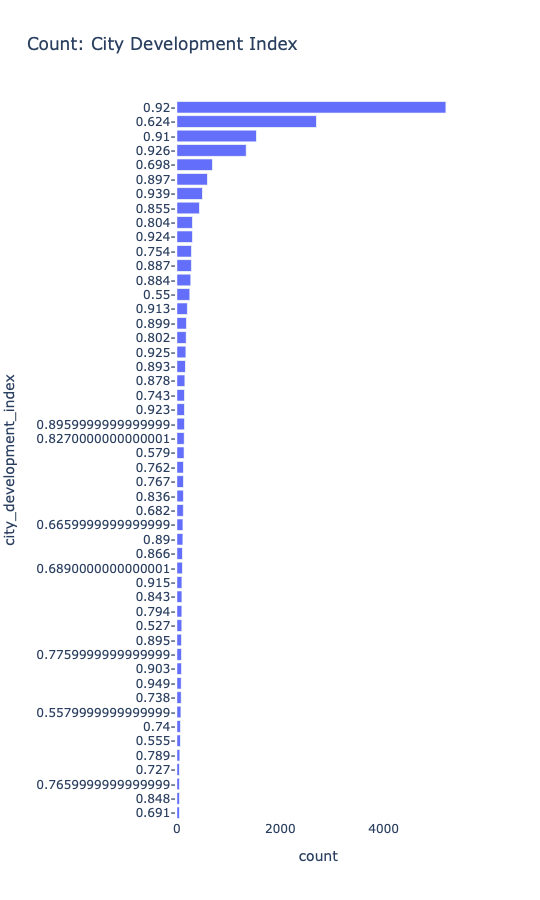

In [86]:
fig = px.bar(
    cdi,
    x='count',
    y='city_development_index',
    orientation='h',
    title='Count: City Development Index',
    width=1000,
    height=900
)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### City : City development index

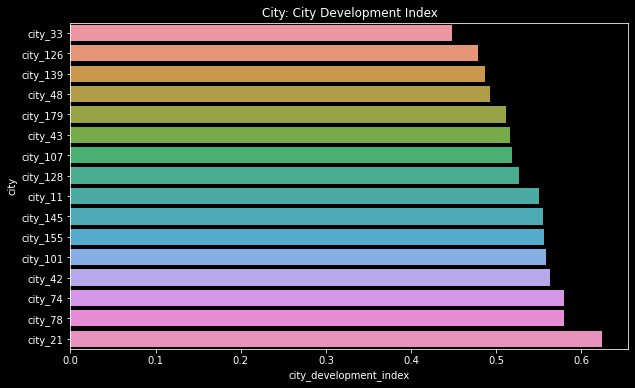

In [87]:
cdi_city = train.sort_values(by='city_development_index', ascending=True)[:2000]
#figure = plt.figure(figsize=(10,6))
plt.figure(figsize=(10,6))
sns.barplot(y=cdi_city.city, x=cdi_city.city_development_index)
plt.xticks()
plt.xlabel('city_development_index')
plt.ylabel('city')
plt.title('City: City Development Index')
plt.show()

Text(0.5, 1.0, 'Distributional of City Development Index')

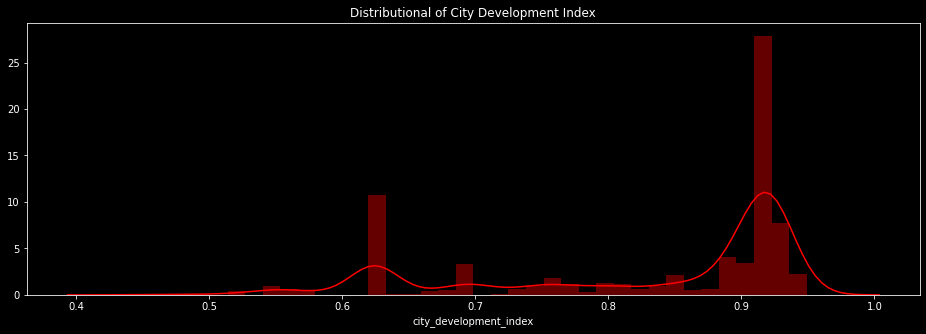

In [88]:
f, axes = plt.subplots(1,1,figsize=(16,5))
g1 = sns.distplot(train['city_development_index'],color='red',ax=axes)
plt.title('Distributional of City Development Index')

Text(0.5, 1.0, 'Distributional of City Development Index')

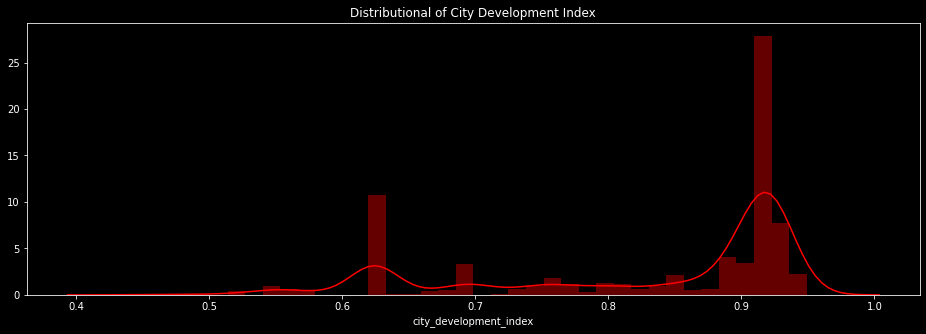

In [90]:
# 같은 코드
plt.figure(figsize=(16,5))
sns.distplot(train['city_development_index'],color='red')
plt.title('Distributional of City Development Index')

### Experience
Enrolee total experience in years

In [91]:
ep = train['experience'].value_counts().reset_index()
ep.columns = [
    'experience',
    'percent'
]
ep['percent'] /= len(train)

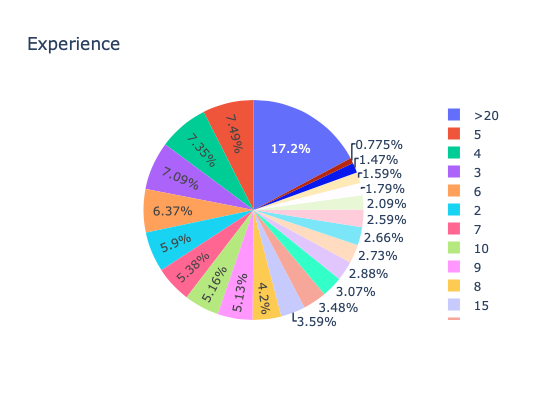

In [95]:
fig = px.pie(
    ep,
    names='experience',
    values='percent',
    title='Experience',
    width=700,
    height=400
)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### Training_hours

Text(0.5, 1.0, 'Distributional of Training Hours')

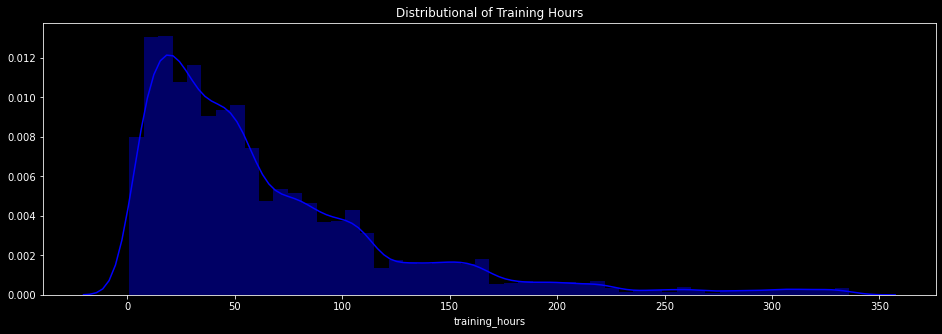

In [96]:
f, axes = plt.subplots(1,1,figsize=(16,5))
g1 = sns.distplot(train['training_hours'], color='blue', ax=axes)
plt.title('Distributional of Training Hours')

Text(0.5, 1.0, 'Distributional of Training Hours')

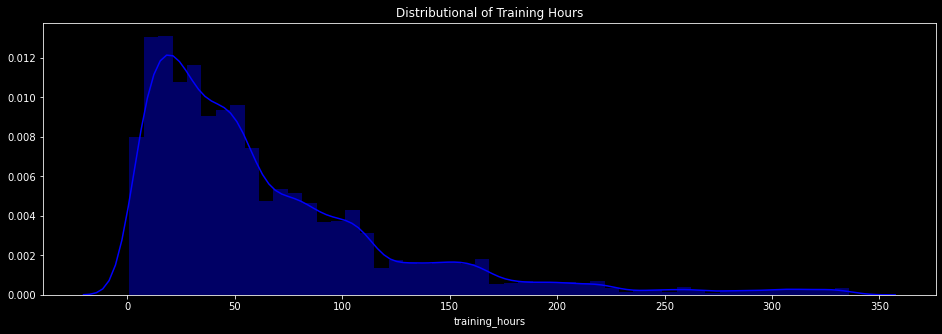

In [97]:
plt.figure(figsize=(16,5))
sns.distplot(train['training_hours'],color='blue')
plt.title('Distributional of Training Hours')